# Choropleth Plot of Sentinel 5P Data

## Loading Data

In [1]:
import glob

import geopandas
import pandas
import s5a

# Read world map
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Read in all files
data = []
for filename in glob.glob('data/S5P_OFFL_L2__NO2____/*.nc'):
    data.append(
        s5a.filter_by_quality(
            s5a.load_ncfile(filename)))

# Combine points
data = pandas.concat(data, ignore_index=True)

# Reduce points
data = s5a.point_to_h3(data, resolution=5)
data = s5a.aggregate_h3(data)
data = s5a.h3_to_point(data)

# Create geopandas dataframe
geometry = geopandas.points_from_xy(data.longitude, data.latitude)
data = geopandas.GeoDataFrame(data, geometry=geometry, crs={'init' :'epsg:4326'})

## Calculate mean value per Country

In [2]:
# Use spacial join to find all points within a country
no2_per_country = geopandas.sjoin(world, data, how='left', op='contains')

# Limit the result to the name of the country and the carbon monoxide value
no2_per_country = no2_per_country[['name', 'value']]

# Calculate the mean value per country
no2_per_country = no2_per_country.groupby(by='name').mean()

# Join the mean value with the world map
no2_per_country = world.join(no2_per_country, on='name')

no2_per_country

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,value
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.000005
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",0.000007
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0.000009
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.000002
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.000016
...,...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",0.000028
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",0.000010
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",0.000023
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",0.000014


## Plotting

/home/sven/devel/emissions-api/sentinel5p-plots/env/lib/python3.8/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


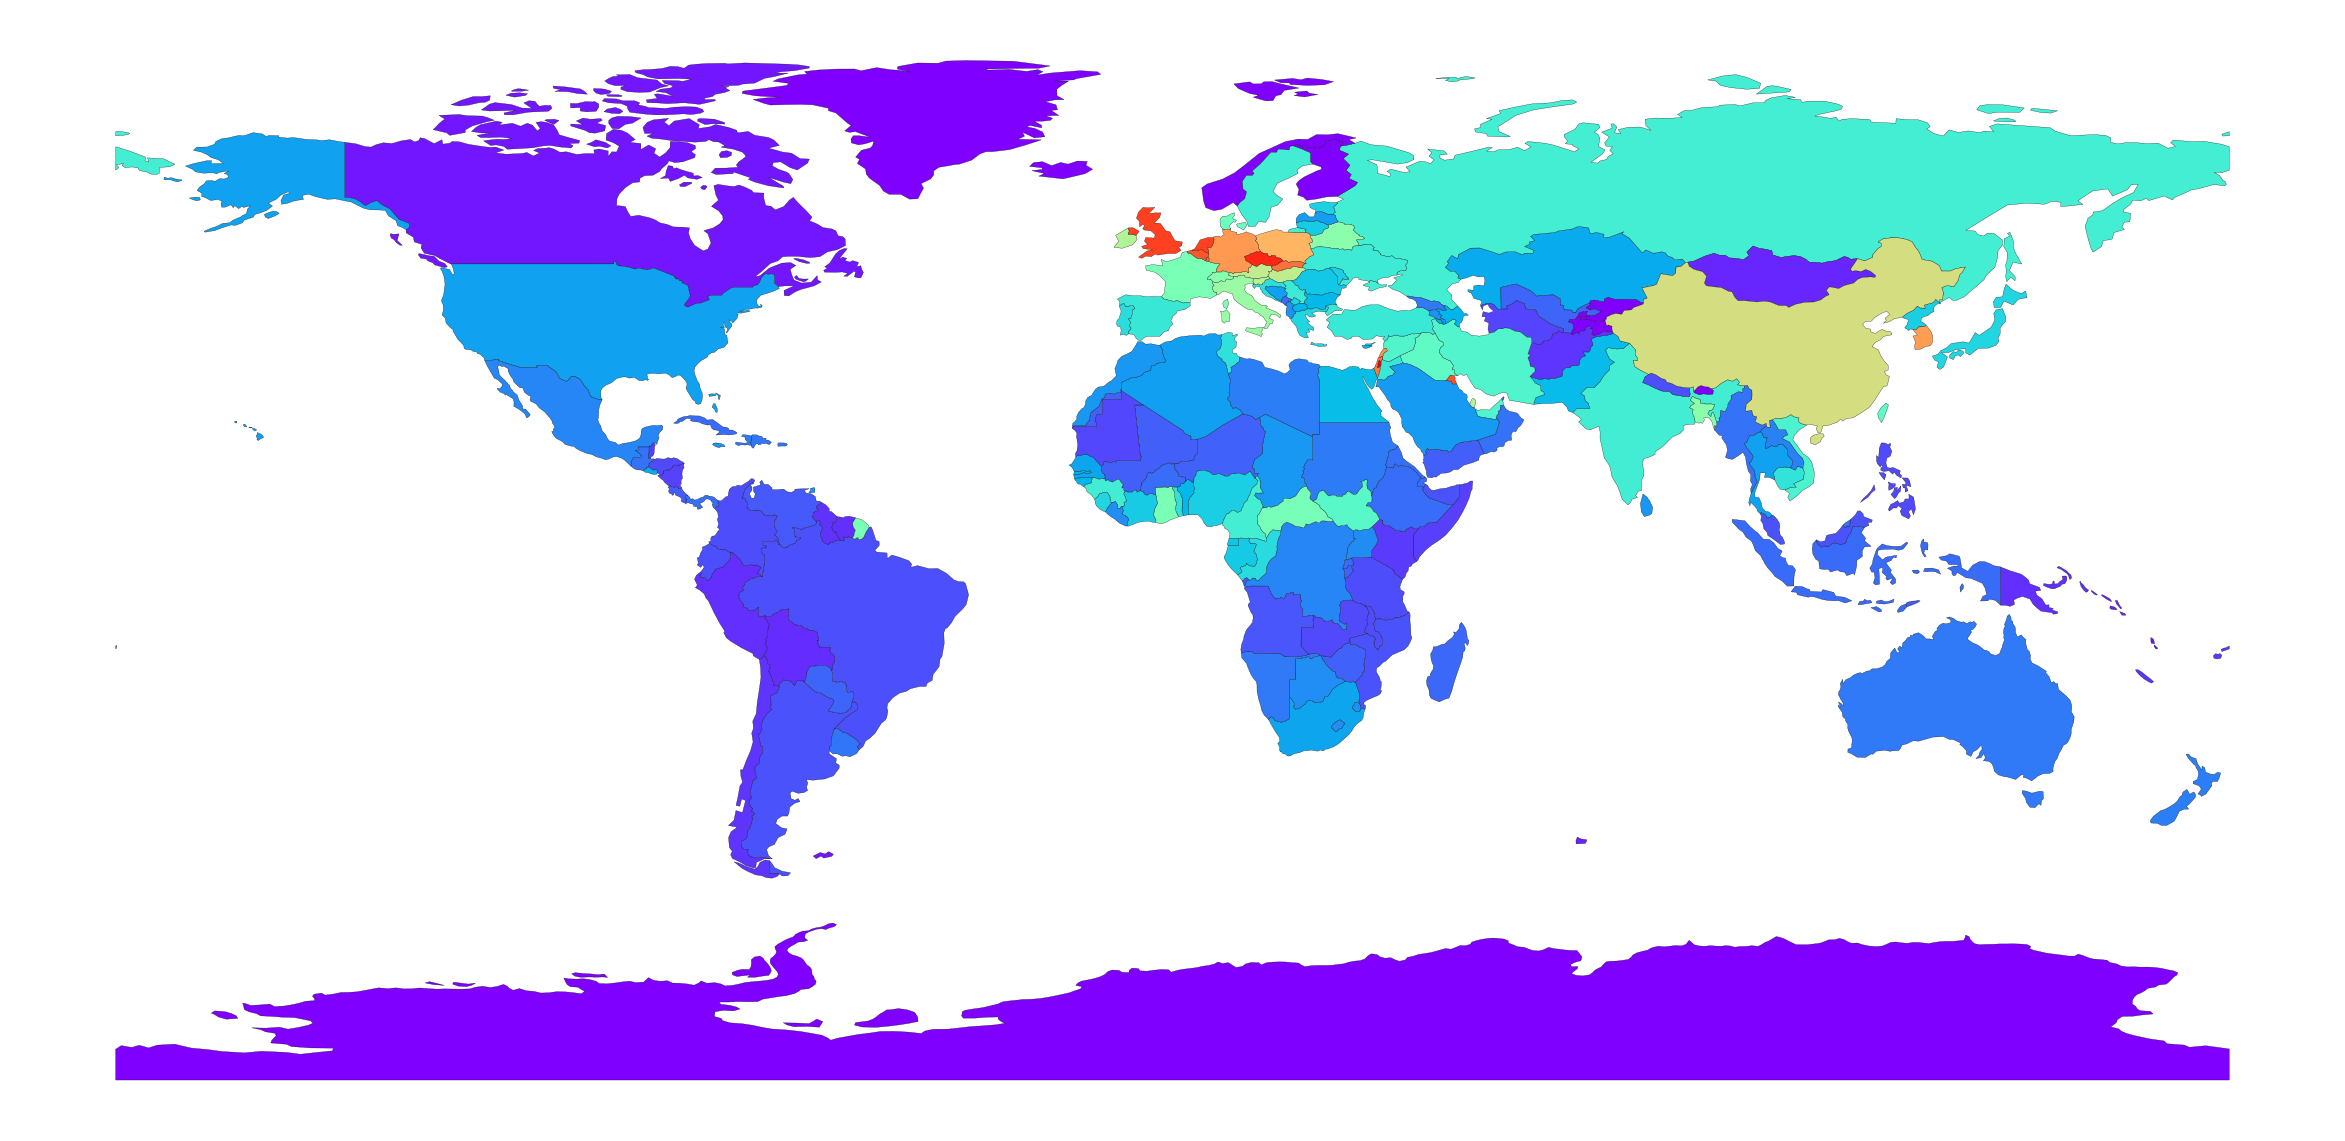

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(30, 30), dpi=100)
ax.set_axis_off()
no2_per_country.plot(
    column='value',
    cmap='rainbow',
    ax=ax,
    edgecolor='black',
    linewidth=0.2,
    vmax=0.000075)